In [1]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive/day49-50/data'
#!git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
#%cd keras-yolo3

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/day49-50/data


In [2]:
import os
if not os.path.exists("model_data/yolo_weights.h5"):
    # 下載 yolov3 的網路權重(.weights)，並且把權重轉換為 keras 能夠讀取的格式(.h5)
    print("Converting pretrained YOLOv3 weights for training")
    #把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重,注意argument 要使用 -w 
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [3]:
# 將 train.py 所需要的套件載入
# 一定要記得設定GPU要使用哪一個空閒的GPU，以免與其他人搶資源
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

# 加入此設定，避免訓練大尺寸圖片時可能發生異常
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [5]:
pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 88kB/s 
     |████████████████████████████████| 491kB 51.9MB/s 
     |████████████████████████████████| 3.2MB 36.3MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [6]:
pip install keras==2.1.5 # 需要安裝 keras 2.2.4 的版本 2.3.1

     |████████████████████████████████| 337kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [4]:

import tensorflow as tf
import sys
print('tensorflow version:', tf.__version__)
print('python version:', sys.version)

tensorflow version: 1.14.0
python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [0]:
import keras

In [7]:
keras.__version__

'2.1.5'

In [0]:
from PIL import Image
image = Image.open('data/all_images/00025.jpg')

In [11]:
# 在yolo.py中並沒有指定使用GPU的功能(只能設定使用多GPU功能卻不能指定GPU index)，所以我在該程式中特別指定了我所要跑的GPU(寫死在yolo.py中)，未來視情況可以自行改寫該程式碼
from yolo import YOLO
log_dir = 'logs/000/'
classes_path = 'model_data/animal_classes.txt'
# 記得選擇訓練結果最好的模型來測試圖片(loss最小)
yolo_model = YOLO(model_path=log_dir + 'ep048-loss20.974-val_loss19.747.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/ep048-loss20.974-val_loss19.747.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (138, 42) (472, 401)
kangaroo 0.82 (21, 109) (551, 328)
3.418590445999996


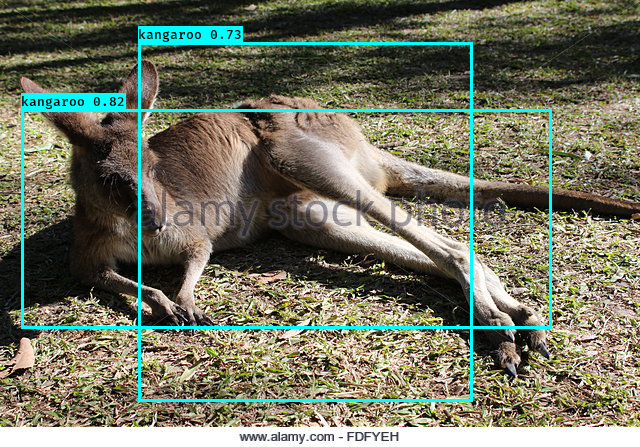

In [12]:
r_image

In [13]:
from yolo import YOLO
log_dir = 'logs/000/'
classes_path = 'model_data/animal_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'ep048-loss20.974-val_loss19.747.h5', classes_path=classes_path)

logs/000/ep048-loss20.974-val_loss19.747.h5 model, anchors, and classes loaded.


In [14]:
import cv2
import numpy as np
from PIL import Image
import timeit

starttime = timeit.default_timer()
cap = cv2.VideoCapture('Kangaroo.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('Kangaroo-object-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

Streaming output truncated to the last 5000 lines.
1.6074792619999698
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (0, 23) (281, 510)
1.5709397299999637
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (0, 44) (291, 473)
1.5783999129998847
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (0, 99) (313, 426)
1.5658844759998374
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (0, 101) (311, 422)
1.5711441779999404
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (0, 108) (287, 425)
1.5518932079999104
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (0, 108) (287, 424)
1.5643578869999146
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (0, 82) (308, 447)
1.5726370480001606
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (623, 409) (917, 700)
kangaroo 0.36 (0, 78) (335, 454)
1.5726154070000575
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (640, 391) (904, 720)
kangaroo 0.41 (0, 107) (324, 411)
1.5549739289999707
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (643, 440) (